Pets revisited

In [0]:
from fastai.vision import *

In [0]:
bs = 64

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
dataset_path = Path("/content/drive/My Drive/fast.ai v3/datasets/oxford-iiit-pet")

In [35]:
dataset_path.ls(

)

[PosixPath('/content/drive/My Drive/fast.ai v3/datasets/oxford-iiit-pet/images'),
 PosixPath('/content/drive/My Drive/fast.ai v3/datasets/oxford-iiit-pet/annotations')]

In [0]:
path = dataset_path/'images'

In [0]:
tfms = get_transforms(max_rotate=20,max_zoom=1.3,max_lighting=0.4,max_warp=0,
                      p_affine=1.,p_lighting=1.)

In [37]:
doc(get_transforms)

In [0]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2,seed=0)

In [0]:
def get_data(size,bs,padding_mode='reflection'):
    """ function for dataprep
    using reflection for padding as default"""
    # brush up on regexes
    return (src.label_from_re(r'([^/]+)_\d+.jpg$').
            transform(tfms,size= size,padding_mode=padding_mode).
            databunch(bs=bs).normalize(imagenet_stats)) 

In [0]:
data = get_data(224,bs,'zeros')

In [0]:
def _plot(i,j,ax):
    """function for plotting a pic's transforms"""
    x,y = data.train_ds[3]
    x.show(ax,y=y)

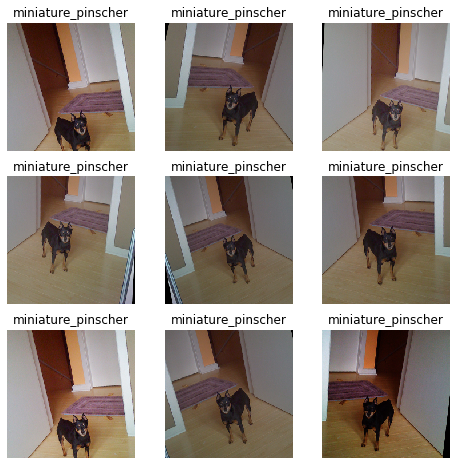

In [51]:
plot_multi(_plot,3,3,figsize=(8,8))

now using the default reflection for padding

In [0]:
data = get_data(224,64)

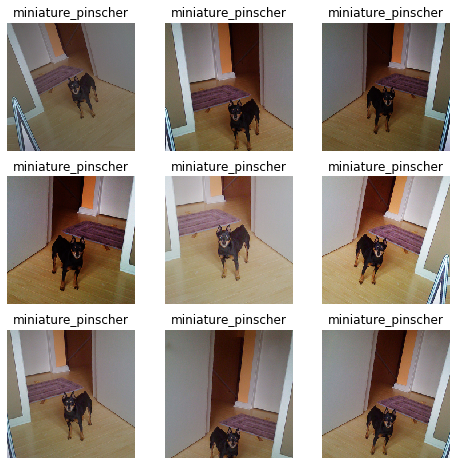

In [54]:
plot_multi(_plot,3,3,figsize=(8,8))

Training

In [58]:
import gc
#manual garbage collection
gc.collect()

71

In [59]:
learn = cnn_learner(data,models.resnet34, metrics = error_rate,bn_final = True)
# using batch norm for final layer

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 38.4MB/s]


In [60]:
doc(cnn_learner)

In [64]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


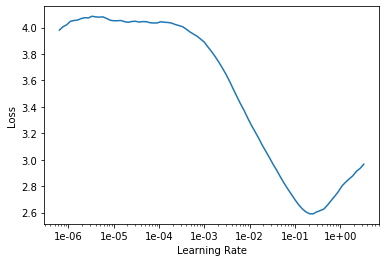

In [65]:
learn.recorder.plot()

In [68]:
learn.fit_one_cycle(3,slice(5e-3,5e-2),pct_start=0.6)
# pct_start defines the percentage of iterations for an epoch for which the learning rate will increase
# using a slightly larger learning rate so using a lower percentage for compensating

epoch,train_loss,valid_loss,error_rate,time
0,0.972192,0.405576,0.115020,07:32
1,0.811445,0.933863,0.257781,01:49
2,0.647910,0.284940,0.082544,01:52


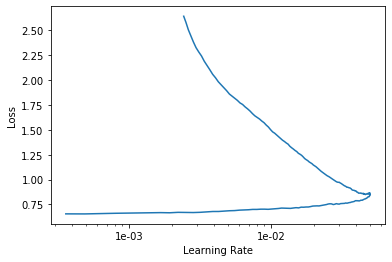

In [69]:
learn.recorder.plot()

 now you know why the loss increased: probably a loss explosion at the higher end of the learning rate: should have gone a bit lower: say 1e-2...

# training a bit more with a lower learning rate to fine tune the approach on the contour

In [0]:
learn.unfreeze()

In [73]:
learn.fit_one_cycle(2,slice(1e-6,1e-3),pct_start = 0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.496223,0.254518,0.075778,01:54
1,0.467277,0.238129,0.071719,01:56


a wee bit more training would be good cause the validation loss is still decreasing 

In [74]:
learn.unfreeze()
learn.fit_one_cycle(1,slice(1e-6,1e-3),pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.411532,0.226749,0.073748,01:57


okay , stopping now

In [78]:
learn.path

PosixPath('/content/drive/My Drive/fast.ai v3/datasets/oxford-iiit-pet/images')

In [0]:
learn.save('256') # saves by default in the above folder

# Creating a Heatmap

using hooks to get into the core weights rather than just the output

In [81]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

take note of the dimensions of the layers

In [82]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

have 37 classes in the end

In [0]:
m = learn.model.eval()

checkout the docs for eval ( pytorch- not fastai)

m is just for testing forward passes: no backprop done by invoking eval()

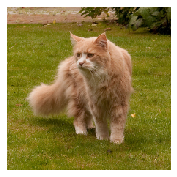

In [85]:
x,y = data.valid_ds[0]
x.show()

In [0]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0]) # picking the first image so see what it activates the most

sending to cuda for forward pass 

In [0]:
xb = xb.cuda()

In [0]:
from fastai.callbacks.hooks import *

In [0]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a:
        with hook_output(m[0],grad=True) as hook_g:
            preds = m(xb)# useless for now
            preds[0,int(cat)].backward()
    return hook_a,hook_g

#checkout the corresponding lesson notes for explanation of this method
# also readup on pytorch docs for hooks

In [0]:
hook_a,hook_g = hooked_backward()

In [94]:
acts = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 7, 7])

In [95]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([7, 7])

In [0]:
# extracted the last extent of activations in avg acts by the above code 
# plotting it in an overlapping fashion with the original image to get an idea of the relevant regions used to identigy the class

In [0]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm,alpha = 0.6,extent = (0,224,224,0),
              interpolation='bilinear',cmap='magma');

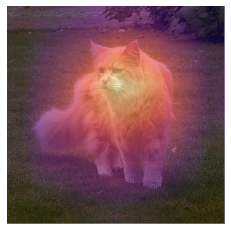

In [102]:
show_heatmap(avg_acts)

cool, makes sense